# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

## Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

#### Data Task Definition

The business objective is to help a used car dealership understand what drives listing prices so they can optimize their inventory strategy. Translated into a data problem, this means:

- **Target variable:** `price` (continuous)
- **Task type:** Supervised regression
- **Goal:** Identify which features (e.g., `year`, `odometer`, `manufacturer`, `fuel`, `type`, `transmission`) have the strongest predictive relationship with price, and quantify the direction and magnitude of each effect.

Using a dataset of ~426K used car listings, we will clean and prepare the data, engineer relevant features, build multiple regression models, and evaluate feature importances to deliver actionable pricing insights.

## Data Understanding

After considering the business understanding, we want to get familiar with our data. We load the dataset, inspect its structure and quality, examine the target variable distribution, and explore feature relationships — all to identify issues that will need to be addressed in Data Preparation.

In [320]:
# --- Libraries ---
import pandas as pd      # Data manipulation and analysis
import numpy as np       # Numerical operations
import matplotlib.pyplot as plt  # Static plotting
import seaborn as sns    # Statistical visualizations built on matplotlib
from sklearn.preprocessing import OneHotEncoder # OneHotEncoder is used to encode categorical variables
from sklearn.model_selection import train_test_split   # train_test_split is used to split the data into training and testing sets
from sklearn.linear_model import Ridge, LinearRegression # Ridge and LinearRegression are used for regression
from sklearn.metrics import mean_squared_error, r2_score  # Evaluation metrics
from sklearn.pipeline import Pipeline              # Pipeline chains preprocessing + model
from sklearn.model_selection import cross_val_score, GridSearchCV  # Cross-validation and hyperparameter tuning
from sklearn.linear_model import Lasso             # Lasso regression (L1 regularization)
from sklearn.preprocessing import StandardScaler   # Feature scaling for regularized models

# --- Load the Kaggle used-car dataset (426K listings) ---
vehicles = pd.read_csv('data/vehicles.csv')
print(f"Dataset loaded: {vehicles.shape[0]:,} rows × {vehicles.shape[1]} columns\n")



Dataset loaded: 426,880 rows × 18 columns



In [321]:
# Preview the first 5 rows to confirm the data loaded correctly
vehicles.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [322]:
# Helper functions for Entire Notebook
# Each function targets one aspect of EDA so cells below can call them cleanly.


# --- Data Inspection ---
def inspect_data(df, key_cols=None):
    """Print dataset shape, duplicate count, missing value percentages, data types,
    and rows missing critical features.
    
    Parameters
    ----------
    df : DataFrame
    key_cols : list[str], optional
        Columns considered essential. Rows where ALL of these are NaN
        are flagged as "nearly-empty" and should be dropped.
        Default: ['year', 'manufacturer', 'model', 'odometer']
    """
    if key_cols is None:
        key_cols = ['year', 'manufacturer', 'model', 'odometer']

    print(f"Shape: {df.shape[0]:,} rows x {df.shape[1]} columns")

    dupes = df.duplicated().sum()
    print(f"Duplicates: {dupes:,}")

    # Missing values as a percentage, sorted worst-first
    print(f"\n{'='*55}")
    print("MISSING VALUES (% of rows):")
    print(f"{'='*55}")
    missing = (df.isnull().mean() * 100).sort_values(ascending=False)
    print(missing[missing > 0].to_string(float_format="{:.1f}%".format))

    # Nearly-empty rows: rows where ALL key columns are NaN
    print(f"\n{'='*55}")
    print("NEARLY-EMPTY ROW CHECK")
    print(f"{'='*55}")
    key_mask = df[key_cols].isnull().all(axis=1)
    n_empty = key_mask.sum()
    pct_empty = n_empty / len(df) * 100
    print(f"  Key columns checked:  {key_cols}")
    print(f"  Rows missing ALL of them:  {n_empty:,}  ({pct_empty:.2f}%)")

    print(f"\n{'='*55}")
    print("DATA TYPES:")
    print(f"{'='*55}")
    print(df.dtypes.value_counts())


def inspect_zero_values(df):
    """Print counts of zero/near-zero and extreme values for price and odometer."""
    checks = {
        'price':    {'threshold': 1,   'label': 'Price = $0'},
        'odometer': {'threshold': 1,   'label': 'Odometer = 0'},
    }

    total = len(df)
    print(f"{'='*50}")
    print("ZERO / NEAR-ZERO VALUE CHECK")
    print(f"{'='*50}")

    for col, info in checks.items():
        if col not in df.columns:
            continue
        count = (df[col] <= info['threshold']).sum()
        pct = count / total * 100
        print(f"  {info['label']:<20}  {count:>7,} rows  ({pct:.2f}%)")

    extreme_checks = {
        'price':    {'threshold': 1_000_000, 'label': 'Price > $1M'},
        'odometer': {'threshold': 500_000,   'label': 'Odometer > 500k'},
    }

    print(f"\n{'='*50}")
    print("EXTREME HIGH VALUE CHECK")
    print(f"{'='*50}")

    for col, info in extreme_checks.items():
        if col not in df.columns:
            continue
        count = (df[col] > info['threshold']).sum()
        pct = count / total * 100
        print(f"  {info['label']:<20}  {count:>7,} rows  ({pct:.2f}%)")


def plot_price_distribution(df):
    """Log-scale boxplot, histogram ($1-$100k), and zero-price bar chart."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Log-scale boxplot so extreme outliers don't crush the axis
    positive_prices = df[df['price'] > 0]['price']
    sns.boxplot(x=positive_prices, ax=axes[0])
    axes[0].set_xscale('log')
    axes[0].set_title("Price Boxplot (log scale, price > $0)")
    axes[0].set_xlabel("price (log scale)")

    # Histogram filtered to realistic range
    clean_price = df[df['price'].between(1, 100_000)]['price']
    sns.histplot(clean_price, bins=50, kde=True, ax=axes[1])
    axes[1].set_title("Price Distribution ($1 - $100k)")

    # Bar chart: $0 vs non-zero
    zero_count = (df['price'] <= 0).sum()
    valid_count = (df['price'] > 0).sum()
    axes[2].bar(['$0 or less', '> $0'], [zero_count, valid_count],
                color=['salmon', 'steelblue'])
    axes[2].set_title("Zero-Price Listings")
    axes[2].set_ylabel("Count")
    for i, v in enumerate([zero_count, valid_count]):
        axes[2].text(i, v + 1000, f"{v:,}", ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()
    print(df['price'].describe())


def inspect_features(df):
    """Print range stats for numeric features only: price and odometer."""
    print(f"{'='*40}")
    print("NUMERIC FEATURE RANGES")
    print(f"{'='*40}")

    print(f"\nPrice Range:    ${df['price'].min():,.0f}  –  ${df['price'].max():,.0f}")
    print(f"Odometer Range: {df['odometer'].min():,.0f}  –  {df['odometer'].max():,.0f}")
    print(f"Year Range:     {df['year'].min():.0f}  –  {df['year'].max():.0f}")

    print(f"\n{'='*40}")
    print("DETAILED STATS")
    print(f"{'='*40}")
    print(df[['price', 'odometer', 'year']].describe())


def visualize_correlations(df):
    """Heatmap of Pearson correlations between numeric features."""
    numeric_df = df.select_dtypes(include=[np.number]).drop(columns=['id'], errors='ignore')

    plt.figure(figsize=(8, 6))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix (Numeric Features)")
    plt.tight_layout()
    plt.show()


def inspect_categorical_details(df, cat_list):
    """Print compact value counts for categorical columns.
    
    - > 8 unique values  → top 5 + total unique count
    - ≤ 8 unique values  → all values shown
    NaN counts are always included.
    """
    for col in cat_list:
        if col not in df.columns:
            continue

        n_unique = df[col].nunique()
        n_null   = df[col].isnull().sum()
        counts   = df[col].value_counts(dropna=False)

        if n_unique > 8:
            print(f"\n--- {col.upper()} ({n_unique:,} unique | {n_null:,} NaN) ---")
            for label, val in counts.head(5).items():
                label_str = "NaN" if pd.isna(label) else str(label)
                print(f"  {label_str:<30} {val:>7,}")
            print(f"  {'...':<30}")
        else:
            print(f"\n--- {col.upper()} ({n_unique:,} unique | {n_null:,} NaN) ---")
            for label, val in counts.items():
                label_str = "NaN" if pd.isna(label) else str(label)
                print(f"  {label_str:<30} {val:>7,}")


# --- Data Assessment ---
def assess_feature_impact(df, col, target='price'):
    """Show median target value per category for a column. 
    Helps decide if a high-missing column is worth imputing or should be dropped.
    """
    # Filter to rows where both the feature and target are non-null
    subset = df[[col, target]].dropna()
    
    # Group by the column and calculate median price and count
    grouped = subset.groupby(col)[target].agg(['median', 'count']).sort_values('median', ascending=False)
    # Rename columns
    grouped.columns = ['Median Price', 'Count']

    # Format median price as currency
    grouped['Median Price'] = grouped['Median Price'].apply(lambda x: f"${x:,.0f}")
    
    print(f"\n{'='*55}")
    print(f"  {col.upper()} → Impact on Price  ({len(subset):,} non-null rows)")
    print(f"{'='*55}")
    print(grouped.to_string())


In [323]:
# Run structural scan: reports shape, duplicates, missing values, and data types
inspect_data(vehicles)

Shape: 426,880 rows x 18 columns
Duplicates: 0

MISSING VALUES (% of rows):
size           71.8%
cylinders      41.6%
condition      40.8%
VIN            37.7%
drive          30.6%
paint_color    30.5%
type           21.8%
manufacturer    4.1%
title_status    1.9%
model           1.2%
odometer        1.0%
fuel            0.7%
transmission    0.6%
year            0.3%

NEARLY-EMPTY ROW CHECK
  Key columns checked:  ['year', 'manufacturer', 'model', 'odometer']
  Rows missing ALL of them:  68  (0.02%)

DATA TYPES:
str        14
int64       2
float64     2
Name: count, dtype: int64


In [324]:
# Report counts of zero/near-zero and extreme values for price and odometer
inspect_zero_values(vehicles)

ZERO / NEAR-ZERO VALUE CHECK
  Price = $0             34,846 rows  (8.16%)
  Odometer = 0            4,211 rows  (0.99%)

EXTREME HIGH VALUE CHECK
  Price > $1M                53 rows  (0.01%)
  Odometer > 500k         1,386 rows  (0.32%)


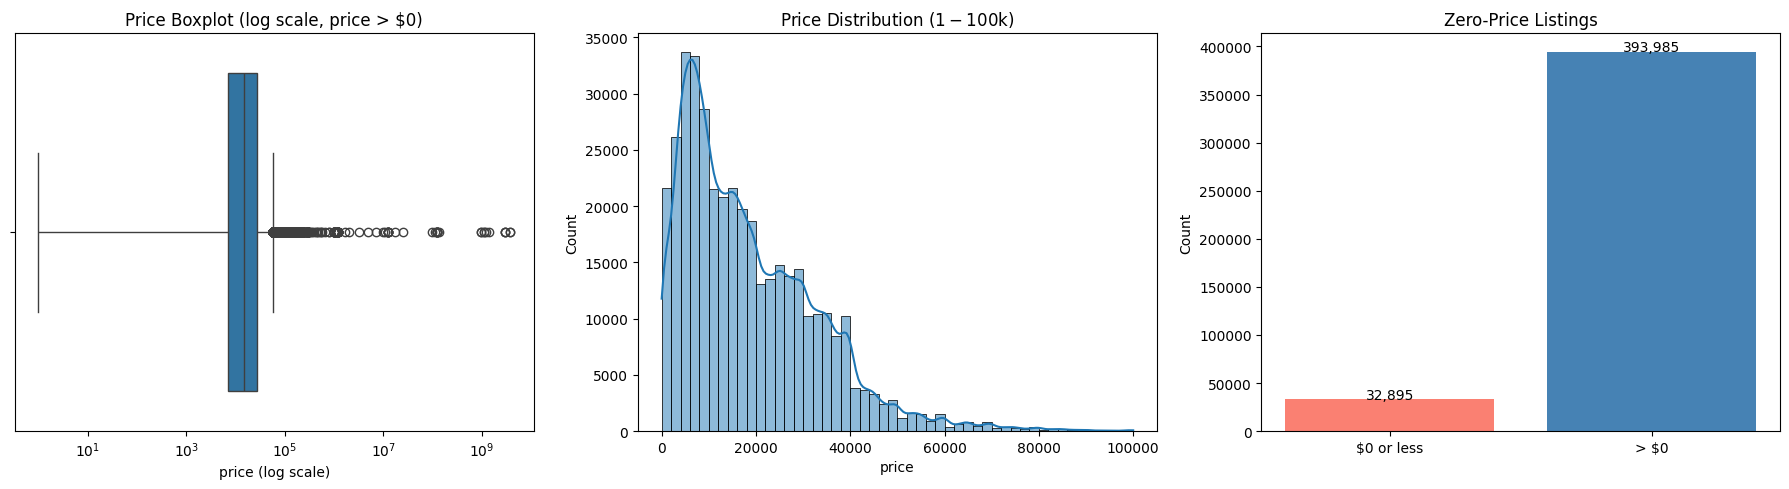

count    4.268800e+05
mean     7.519903e+04
std      1.218228e+07
min      0.000000e+00
25%      5.900000e+03
50%      1.395000e+04
75%      2.648575e+04
max      3.736929e+09
Name: price, dtype: float64


In [325]:
# Visualize price: log-scale boxplot, histogram, and zero-price count
plot_price_distribution(vehicles)

In [326]:
# Validate year/odometer ranges and check the most common manufacturers
inspect_features(vehicles)

NUMERIC FEATURE RANGES

Price Range:    $0  –  $3,736,928,711
Odometer Range: 0  –  10,000,000
Year Range:     1900  –  2022

DETAILED STATS
              price      odometer           year
count  4.268800e+05  4.224800e+05  425675.000000
mean   7.519903e+04  9.804333e+04    2011.235191
std    1.218228e+07  2.138815e+05       9.452120
min    0.000000e+00  0.000000e+00    1900.000000
25%    5.900000e+03  3.770400e+04    2008.000000
50%    1.395000e+04  8.554800e+04    2013.000000
75%    2.648575e+04  1.335425e+05    2017.000000
max    3.736929e+09  1.000000e+07    2022.000000


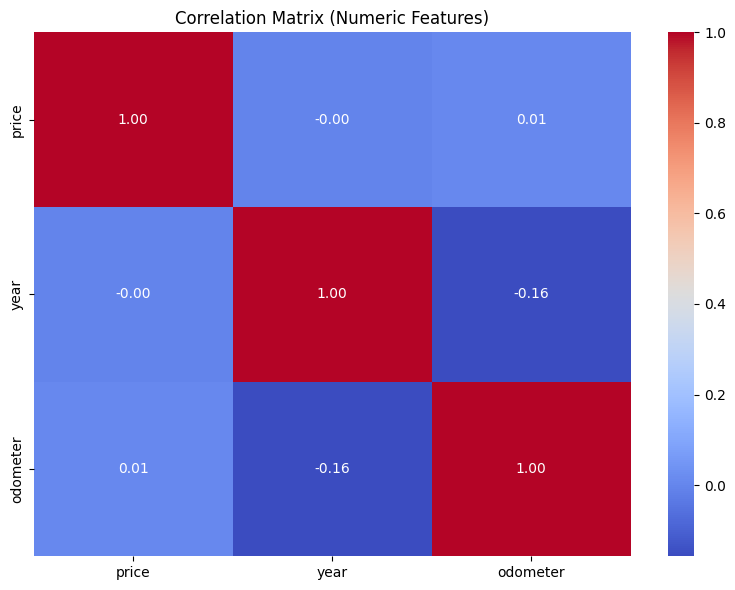

In [327]:
# Heatmap of Pearson correlations — look for strong relationships with price
visualize_correlations(vehicles)

In [328]:
# Value counts for categorical columns — informs encoding and imputation strategy
# If results are truncated you can change the settings of your notebook to see everything or comment out this section. 
categorical_cols = ['fuel', 'title_status', 'transmission', 'drive',  'type',
            'condition', 'paint_color', 'state', 'model','manufacturer', 'region']
            
inspect_categorical_details(vehicles, categorical_cols)


--- FUEL (5 unique | 3,013 NaN) ---
  gas                            356,209
  other                           30,728
  diesel                          30,062
  hybrid                           5,170
  NaN                              3,013
  electric                         1,698

--- TITLE_STATUS (6 unique | 8,242 NaN) ---
  clean                          405,117
  NaN                              8,242
  rebuilt                          7,219
  salvage                          3,868
  lien                             1,422
  missing                            814
  parts only                         198

--- TRANSMISSION (3 unique | 2,556 NaN) ---
  automatic                      336,524
  other                           62,682
  manual                          25,118
  NaN                              2,556

--- DRIVE (3 unique | 130,567 NaN) ---
  4wd                            131,904
  NaN                            130,567
  fwd                            105,517
  rwd        

### Data Inspection Summary

#### 1. How much missing data did I find, and in which columns?

By running `inspect_data(vehicles)`, the following missing-data percentages were identified:

| Column         | % Missing |
|----------------|-----------|
| size           | 71.8%     |
| cylinders      | 41.6%     |
| condition      | 40.8%     |
| VIN            | 37.7%     |
| drive          | 30.6%     |
| paint_color    | 30.5%     |
| type           | 21.8%     |
| manufacturer   | 4.1%      |
| title_status   | 1.9%      |
| model          | 1.2%      |
| odometer       | 1.0%      |
| fuel           | 0.7%      |
| transmission   | 0.6%      |
| year           | 0.3%      |

> **Takeaway:** `size`, `cylinders`, and `condition` are each missing 40–72% of their values. These columns will need careful imputation or may need to be dropped depending on modeling strategy.

---

#### 2. What did the price distribution look like?

Running `inspect_zero_values(vehicles)` revealed a significant number of outliers on **both ends** of the price and odometer scales. The price distribution is **right-skewed**, with the bulk of listings under $20,000.

| Check                | Count        | % of Dataset |
|----------------------|--------------|--------------|
| Price = $0           | 34,846 rows  | 8.16%        |
| Odometer = 0         | 4,211 rows   | 0.99%        |
| Price > $1M          | 53 rows      | 0.01%        |
| Odometer > 500k      | 1,386 rows   | 0.32%        |

> **Takeaway:** ~8% of listings have a price of $0 — these are likely placeholder or "contact for price" entries and must be removed before modeling. Extreme highs (>$1M) are also noise.

---

#### 3. What quality issues were found?

Running `visualize_correlations(vehicles)` produced a correlation matrix showing **weak correlations** across all numeric features. This is expected at this stage because the data has not been cleaned — the $0 prices, extreme outliers, and missing values are masking the true relationships.

Beyond the price and odometer outliers, the inspection revealed several additional data quality concerns:

- **Nearly-empty rows:** Some rows have nearly all columns as NaN (only `region`, `price`, and `state` populated). These rows carry no useful feature information and should be dropped outright.
- **Unrealistic `year` values:** The year range spans 1900–2022. Listings from 1900 are almost certainly data entry errors or placeholder values and should be filtered out during preparation — a reasonable cutoff (e.g., 1990 or 2000) will need to be chosen.
- **Identifier columns (`id`, `VIN`):** These are row-level identifiers with no predictive value. They should be **dropped before modeling** — they would only add noise if included as features.
- **`model` cardinality (29,649 unique):** This is far too high for direct encoding. Options include grouping into broader categories, using only `manufacturer` instead, or engineering a popularity-based feature from model counts.
- **`region` vs `state` redundancy:** With 404 regions and 51 states, these columns overlap significantly. Keeping both would introduce multicollinearity — likely only `state` (or neither) should be retained.

> **Takeaway:** Correlation analysis will need to be re-run **after** the Data Preparation step (outlier removal, imputation, and feature engineering) to reveal meaningful patterns.

---

#### 4. Recommendations for Data Preparation

Based on the findings above, the following actions should be taken before modeling:

| Action | Details |
|--------|---------|
| **Drop identifiers** | Remove `id` and `VIN` — they are row identifiers with no predictive value |
| **Drop / impute high-missing columns** | `size` (71.8%), `cylinders` (41.6%), `condition` (40.8%) — evaluate whether each can be reliably imputed or should be dropped |
| **Remove price outliers** | Filter out $0 listings (~8%) and listings >$1M (~0.01%) which represent noise, not real market prices |
| **Remove odometer outliers** | Filter listings with 0 or >500k miles that skew the distribution |
| **Filter unrealistic years** | Remove listings with `year` values that are clearly erroneous (e.g., before 1990) |
| **Resolve `model` high cardinality** | 29,649 unique values — too many for encoding; consider grouping, dropping, or engineering a frequency-based feature |
| **Resolve `region` / `state` redundancy** | 404 regions vs 51 states — pick one or drop both to avoid multicollinearity |
| **Feature engineering** | Create derived features such as `age` (current year − `year`) and `miles_per_year` (`odometer` ÷ `age`) |
| **Encode categoricals** | Apply ordinal or one-hot encoding for features like `fuel`, `transmission`, `drive`, `condition`, etc. |
| **Re-run correlation analysis** | After cleaning and feature engineering, re-evaluate feature relationships with `price` |

---

## Data Preparation

---


After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [329]:
# --- Data Preparation: Step 1 — Drop identifier columns ---

# Drop identifiers
vehicles = vehicles.drop(columns=["id", "VIN"])
vehicles.head()


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


#### Step 2 — Should we keep `size`, `cylinders`, and `condition`?

These three columns are missing 40–72% of their data. Before deciding to drop or impute them, we need to check: **does the feature actually influence price?**

The test is simple — group by each column's values and compare the **median price**. If median price varies significantly across categories, the feature carries signal and is worth imputing. If it's flat, we can safely drop it.

In [330]:
# --- Data Preparation: Step 2 — Assess high-missing columns ---

# Test all three high-missing columns
for col in ['condition', 'cylinders', 'size']:
    assess_feature_impact(vehicles, col)


  CONDITION → Impact on Price  (252,776 non-null rows)
          Median Price   Count
condition                     
good           $19,995  121456
new            $15,900    1305
like new       $13,950   21178
excellent      $10,995  101467
fair            $2,800    6769
salvage         $1,800     601

  CYLINDERS → Impact on Price  (249,202 non-null rows)
             Median Price  Count
cylinders                       
12 cylinders      $28,990    209
8 cylinders       $18,900  72062
10 cylinders      $14,995   1455
6 cylinders       $13,995  94169
other              $9,992   1298
3 cylinders        $9,990    655
4 cylinders        $8,500  77642
5 cylinders        $6,200   1712

  SIZE → Impact on Price  (120,519 non-null rows)
            Median Price  Count
size                           
full-size        $10,995  63465
mid-size          $8,495  34476
sub-compact       $7,995   3194
compact           $7,897  19384


In [331]:
#  The spread on size is not enough (weak signal + 71.8% missing) to make us keep this column so it's dropped. 
vehicles = vehicles.drop(columns=["size"])

# What to do with cylinders and condition my options are 
# 1. Drop the rows where condition or cylinders is NaN 
# 2. Impute (fill in) the missing values with something 

# Let's check the shape of the dataframe if we drop the NaN values
print("Shape of the dataframe if we drop the NaN values for condition: ", vehicles.dropna(subset=['condition']).shape)
print("Shape of the dataframe if we drop the NaN values for cylinders: ", vehicles.dropna(subset=['cylinders']).shape)

# If dropping each one alone gives me roughly ~220-230K, but dropping both gives me 181K, that means there's significant overlap but not complete overlap.
# I'm going to drop both because I don't want to lose too much data.

# Drop the rows where condition or cylinders is NaN 
vehicles = vehicles.drop(columns=["condition", "cylinders"])

# Here is my current Hypothesis:
# I might be able to infer the condition and cylinders of the car based on the other features.

# Condition proxies:
    # title_status (only 1.9% missing) — a "salvage" title tells me the car was damaged. A "clean" title suggests decent condition. Not a perfect substitute for condition, but captures some of the same signal.
    # year + odometer — older cars with high mileage are probably in worse condition

# Cylinders proxies:
    # type (21.8% missing) — trucks/pickups tend to be 6-8 cylinders, sedans tend to be 4-6
    # manufacturer (4.1% missing) — certain brands skew toward certain engine sizes
    # fuel (0.7% missing) — diesel vehicles tend to have more cylinders

# This is not perfect, but my customer values accuracy and I want more data to work with.






Shape of the dataframe if we drop the NaN values for condition:  (252776, 15)
Shape of the dataframe if we drop the NaN values for cylinders:  (249202, 15)


In [332]:
# --- Data Preparation: Steps 3, 4 & 5 — Filter outliers ---

# Keep only rows where price is between $1 and $1,000,000
vehicles = vehicles[(vehicles['price'] > 0) & (vehicles['price'] <= 1_000_000)]

# Remove extreme odometer values
vehicles = vehicles[(vehicles['odometer'] > 0) & (vehicles['odometer'] <= 500_000)]

# Remove unrealistic years
vehicles = vehicles[vehicles['year'] >= 1990]


# Verify shape after filtering
vehicles.shape


(376632, 13)

In [333]:
# --- Data Preparation: Step 6 — Resolve high-cardinality & redundant columns ---

# model has 29,649 unique values — far too many for any encoding approach.
# manufacturer (42 unique) already captures the brand signal.
# Dropping model and keeping manufacturer is the practical choice.

# region (404 unique) overlaps heavily with state (51 unique).
# Keeping both would introduce multicollinearity (meaning the model will have a hard time distinguishing between the two) — drop region, keep state.

vehicles = vehicles.drop(columns=['model', 'region'])
print(f"After dropping model & region: {vehicles.shape}")

After dropping model & region: (376632, 11)


In [334]:
# --- Data Preparation: Step 7 — Drop rows missing essential features ---

# The remaining columns have low missing rates (0.3% – 4.1%).
# Dropping rows with NaN in these core features is safe — minimal data loss.
# Columns like drive (30.6%), type (21.8%), paint_color (30.5%) are optional
# and will be filled with "unknown" during encoding instead of dropping rows.

essential_cols = ['year', 'manufacturer', 'odometer', 'fuel', 'transmission', 'title_status']
vehicles = vehicles.dropna(subset=essential_cols)
print(f"After dropping NaN in essential columns: {vehicles.shape}")

After dropping NaN in essential columns: (354624, 11)


In [335]:
# --- Data Preparation: Step 8 — Feature engineering ---

# age: how old the car is (more intuitive than raw year for a regression model)
vehicles['age'] = 2025 - vehicles['year']
vehicles['age'] = vehicles['age'].clip(lower=1)  # floor at 1 to avoid division by zero

# miles_per_year: usage intensity — a high-mileage young car is different from a low-mileage old car
vehicles['miles_per_year'] = vehicles['odometer'] / vehicles['age']

# year is now redundant with age — drop it to avoid multicollinearity
vehicles = vehicles.drop(columns=['year'])

print(f"After feature engineering: {vehicles.shape}")
vehicles[['age', 'miles_per_year', 'odometer', 'price']].describe()

After feature engineering: (354624, 12)


,age,miles_per_year,odometer,price
count,354624.000000,354624.000000,354624.000000,354624.000000
mean,12.631147,7111.627479,93174.694897,19014.677064
std,5.788651,3958.911591,63352.718817,15483.055591
min,3.000000,0.028571,1.000000,1.000000
25%,8.000000,4237.321429,38700.000000,7495.000000
50%,11.000000,6917.916667,88000.000000,15795.500000
75%,16.000000,9500.000000,136000.000000,27990.000000
max,35.000000,75000.000000,500000.000000,1000000.000000


In [336]:
# --- Data Preparation: Step 9 — Encode categoricals for sklearn ---

# Fill remaining NaN in categorical columns with "unknown" before encoding.
# This preserves rows (especially drive, type, paint_color which are 21-31% missing)
# rather than dropping them.



cat_cols = ['fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'manufacturer', 'state']

# Fill NaN with "unknown"
for col in cat_cols:
    vehicles[col] = vehicles[col].fillna('unknown')

# OneHotEncoder — sparse_output=False gives us a dense array, drop="first" avoids multicollinearity
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
encoded_array = encoder.fit_transform(vehicles[cat_cols])

# Build a DataFrame from the encoded columns
encoded_cols = encoder.get_feature_names_out(cat_cols)
encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=vehicles.index)

# Drop the original categorical columns and join the encoded ones
vehicles_encoded = vehicles.drop(columns=cat_cols).join(encoded_df)

print(f"Final encoded shape: {vehicles_encoded.shape}")
vehicles_encoded.head()

Final encoded shape: (354624, 133)


,price,odometer,age,miles_per_year,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,title_status_lien,title_status_missing,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
27,33590,57923.0,11.0,5265.727273,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,22590,71229.0,15.0,4748.600000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,39590,19160.0,5.0,3832.000000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,30990,41124.0,8.0,5140.500000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,15000,128000.0,12.0,10666.666667,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [337]:
# --- Data Preparation: Step 10 — Drop odometer (multicollinearity) ---

# Post-cleaning correlation shows odometer ↔ miles_per_year = 0.79
# That is high multicollinearity — the model would struggle to separate their effects.
#
# miles_per_year is the better feature to keep because it normalizes mileage by age:
#   - A 5-year-old car with 100k miles (20k/yr) ≠ a 15-year-old car with 100k miles (6.7k/yr)
#   - Raw odometer cannot distinguish that; miles_per_year can.
#
# Keeping age + miles_per_year captures everything odometer did, decomposed into
# two independent signals the model can use more effectively.

vehicles_encoded = vehicles_encoded.drop(columns=['odometer'])
print(f"After dropping odometer: {vehicles_encoded.shape}")

After dropping odometer: (354624, 132)


#### Data Preparation Summary

The following steps were applied to transform the raw dataset into a modeling-ready DataFrame:

| Step | Action | Result |
|------|--------|--------|
| 1 | Dropped `id` and `VIN` (identifiers) | Removed 2 non-predictive columns |
| 2 | Assessed `size`, `cylinders`, `condition` | Determined impact on price via median-price groupings |
| 3 | Dropped `size`, `condition`, `cylinders` | `size` had weak signal; `condition` and `cylinders` dropped with proxy reasoning documented |
| 4 | Filtered price ($1–$1M), odometer (1–500k), year (≥1990) | Removed outliers and erroneous entries |
| 5 | Dropped `model` (29k unique) and `region` (redundant with `state`) | Resolved high-cardinality and redundancy issues |
| 6 | Dropped rows missing essential columns | Minimal loss — these columns had <5% missing |
| 7 | Engineered `age` and `miles_per_year`; dropped `year` | Added derived features, removed redundant source column |
| 8 | Dropped `odometer` | Correlated 0.79 with `miles_per_year` — multicollinearity resolved by keeping the more informative derived feature |
| 9 | Filled categorical NaN with "unknown", then `OneHotEncoder` | Produced final feature matrix for sklearn |

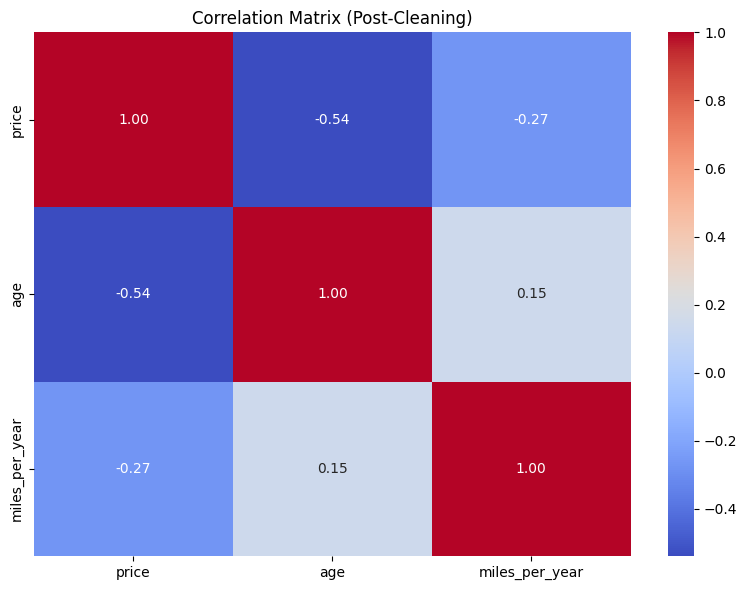

In [338]:
# --- Data Preparation: Step 11 — Re-run correlation analysis on cleaned data ---

# Now that outliers and noise are removed, correlations should be more meaningful.
# Focus on the core numeric features to keep the heatmap readable.

numeric_cols = ['price', 'age', 'miles_per_year']

plt.figure(figsize=(8, 6))
sns.heatmap(vehicles_encoded[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Post-Cleaning)')
plt.tight_layout()
plt.show()

#### Categorical Feature Visualizations

Before modeling, let's visualize how key categorical features relate to price. These plots help us understand which categories command premiums or discounts.

/var/folders/_c/bc47zhgx71v18wqymdf7h8zm0000gn/T/ipykernel_25764/1355200730.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
/var/folders/_c/bc47zhgx71v18wqymdf7h8zm0000gn/T/ipykernel_25764/1355200730.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')


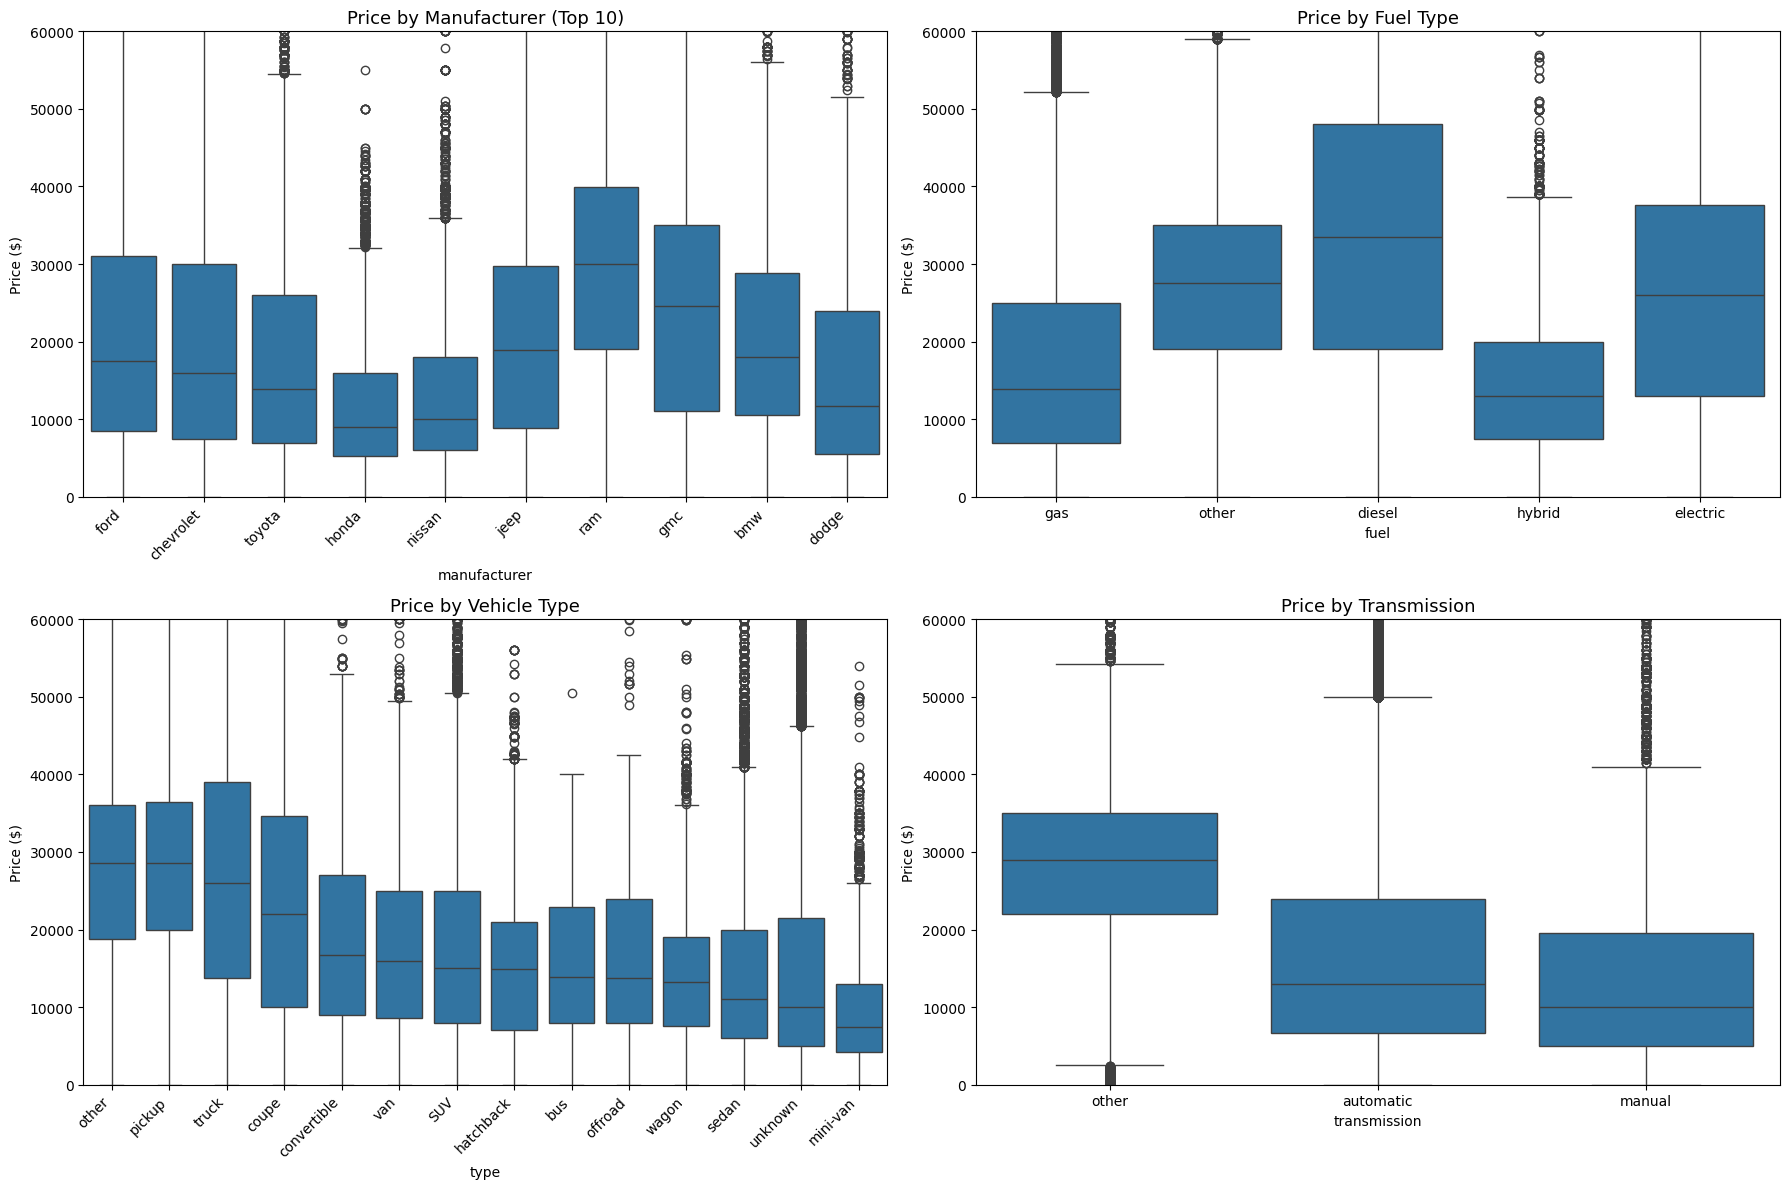

In [339]:
# --- Categorical Visualizations — Price by key features ---

# Use the pre-encoded vehicles DataFrame (before one-hot)
# so we still have the readable category names.

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Price by Manufacturer (top 10 by listing count)
top_mfr = vehicles['manufacturer'].value_counts().head(10).index
mfr_data = vehicles[vehicles['manufacturer'].isin(top_mfr)]
sns.boxplot(data=mfr_data, x='manufacturer', y='price', ax=axes[0, 0], order=top_mfr)
axes[0, 0].set_title('Price by Manufacturer (Top 10)', fontsize=13)
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
axes[0, 0].set_ylim(0, 60000)
axes[0, 0].set_ylabel('Price ($)')

# 2. Price by Fuel Type
sns.boxplot(data=vehicles, x='fuel', y='price', ax=axes[0, 1])
axes[0, 1].set_title('Price by Fuel Type', fontsize=13)
axes[0, 1].set_ylim(0, 60000)
axes[0, 1].set_ylabel('Price ($)')

# 3. Price by Vehicle Type
type_order = vehicles.groupby('type')['price'].median().sort_values(ascending=False).index
sns.boxplot(data=vehicles, x='type', y='price', ax=axes[1, 0], order=type_order)
axes[1, 0].set_title('Price by Vehicle Type', fontsize=13)
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')
axes[1, 0].set_ylim(0, 60000)
axes[1, 0].set_ylabel('Price ($)')

# 4. Price by Transmission
sns.boxplot(data=vehicles, x='transmission', y='price', ax=axes[1, 1])
axes[1, 1].set_title('Price by Transmission', fontsize=13)
axes[1, 1].set_ylim(0, 60000)
axes[1, 1].set_ylabel('Price ($)')

plt.tight_layout()
plt.show()

## Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

#### Model Selection Rationale

We will compare three linear regression models, each building on the last:

1. **Linear Regression** — The baseline. No regularization; just minimizes squared error. Gives us a starting point to measure whether regularization actually helps.
2. **Ridge Regression (L2)** — Adds a penalty on large coefficients. This is important here because our one-hot encoded categoricals create many correlated features, and plain Linear Regression can produce unstable, inflated coefficients in that situation. Ridge shrinks them toward zero.
3. **Lasso Regression (L1)** — Similar penalty, but drives some coefficients to *exactly* zero. This acts as built-in feature selection — with 100+ encoded columns, Lasso tells us which features the model considers irrelevant. That directly answers our business question: *what drives price?*

Each model is evaluated with **RMSE** (root mean squared error — gives us the average prediction error in dollars) and **R²** (the percentage of price variance the model explains). We use **5-fold cross-validation** to get robust estimates, and **GridSearchCV** to tune the regularization strength (`alpha`).

In [340]:
# --- Modeling: Step 1 — Train/test split ---

# Separate features (X) from target (y)
X = vehicles_encoded.drop(columns=['price'])
y = vehicles_encoded['price']

# 80/20 split — train on 80%, evaluate on the held-out 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]:,} rows")
print(f"Test set:     {X_test.shape[0]:,} rows")

Training set: 283,699 rows
Test set:     70,925 rows


In [341]:
# --- Modeling: Step 2 — Baseline model (Linear Regression) ---

# Linear Regression with no regularization — serves as our baseline
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

# Fit on TRAINING data only
lr_pipe.fit(X_train, y_train)

# Predict on TEST data
lr_preds = lr_pipe.predict(X_test)

# Evaluate with RMSE (in dollars) and R² (% of variance explained)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_r2 = r2_score(y_test, lr_preds)

print(f"Linear Regression")
print(f"  RMSE: ${lr_rmse:,.0f}")
print(f"  R²:   {lr_r2:.4f}")

Linear Regression
  RMSE: $8,976
  R²:   0.6326


In [342]:
# --- Modeling: Step 3 — Ridge Regression (L2 regularization) ---

# Ridge penalizes large coefficients — helps with multicollinearity
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))
])

ridge_pipe.fit(X_train, y_train)
ridge_preds = ridge_pipe.predict(X_test)

ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))
ridge_r2 = r2_score(y_test, ridge_preds)

print(f"Ridge Regression (alpha=1.0)")
print(f"  RMSE: ${ridge_rmse:,.0f}")
print(f"  R²:   {ridge_r2:.4f}")

Ridge Regression (alpha=1.0)
  RMSE: $8,976
  R²:   0.6326


In [343]:
# --- Modeling: Step 4 — Lasso Regression (L1 regularization) ---

# Lasso drives some coefficients to exactly zero — built-in feature selection
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=1.0, max_iter=10000))
])

lasso_pipe.fit(X_train, y_train)
lasso_preds = lasso_pipe.predict(X_test)

lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_preds))
lasso_r2 = r2_score(y_test, lasso_preds)

print(f"Lasso Regression (alpha=1.0)")
print(f"  RMSE: ${lasso_rmse:,.0f}")
print(f"  R²:   {lasso_r2:.4f}")

Lasso Regression (alpha=1.0)
  RMSE: $8,976
  R²:   0.6326


In [344]:
# --- Modeling: Step 5 — Cross-validation (5-fold) ---

# Cross-validation gives a more robust estimate of model performance
# by training and evaluating on 5 different train/test splits.
# scoring="neg_mean_squared_error" because sklearn maximizes scores (so MSE is negated)

models = {
    'Linear Regression': Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())]),
    'Ridge (alpha=1.0)':  Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=1.0))]),
    'Lasso (alpha=1.0)':  Pipeline([('scaler', StandardScaler()), ('model', Lasso(alpha=1.0, max_iter=10000))]),
}

print(f"{'Model':<25} {'Mean CV RMSE':>15} {'Std CV RMSE':>15}")
print("=" * 57)

for name, pipe in models.items():
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)  # convert negative MSE → positive RMSE
    print(f"{name:<25} ${cv_rmse.mean():>12,.0f} ${cv_rmse.std():>12,.0f}")

Model                        Mean CV RMSE     Std CV RMSE
Linear Regression         $      10,266 $         841
Ridge (alpha=1.0)         $      10,266 $         841
Lasso (alpha=1.0)         $      10,266 $         841


In [345]:
# --- Modeling: Step 6 — Hyperparameter tuning with GridSearchCV ---

# Test a range of alpha values for Ridge to find the best regularization strength
ridge_grid = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Define the parameter grid — alpha controls regularization strength
param_grid = {'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}

# GridSearchCV tests each alpha with 5-fold cross-validation
grid_search = GridSearchCV(ridge_grid, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best result
best_alpha = grid_search.best_params_['ridge__alpha']
best_rmse = np.sqrt(-grid_search.best_score_)

print(f"Best Ridge alpha: {best_alpha}")
print(f"Best CV RMSE:     ${best_rmse:,.0f}")

# Evaluate the best model on the held-out test set
best_preds = grid_search.predict(X_test)
best_rmse_test = np.sqrt(mean_squared_error(y_test, best_preds))
best_r2_test = r2_score(y_test, best_preds)

print(f"\nTest set performance (best Ridge):")
print(f"  RMSE: ${best_rmse_test:,.0f}")
print(f"  R²:   {best_r2_test:.4f}")

0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0

Best Ridge alpha: 10.0
Best CV RMSE:     $10,300

Test set performance (best Ridge):
  RMSE: $8,976
  R²:   0.6326


In [346]:
# --- Modeling: Step 6b — Hyperparameter tuning for Lasso ---

# Lasso's value is feature selection — it zeros out irrelevant coefficients.
# But alpha=1.0 may not be optimal. Too high → everything gets zeroed out.
# Too low → no regularization benefit. Let GridSearchCV find the sweet spot.

lasso_grid = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=10000))
])

lasso_param_grid = {'lasso__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}

lasso_search = GridSearchCV(lasso_grid, lasso_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_search.fit(X_train, y_train)

best_lasso_alpha = lasso_search.best_params_['lasso__alpha']
best_lasso_cv_rmse = np.sqrt(-lasso_search.best_score_)

print(f"Best Lasso alpha: {best_lasso_alpha}")
print(f"Best CV RMSE:     ${best_lasso_cv_rmse:,.0f}")

lasso_best_preds = lasso_search.predict(X_test)
lasso_best_rmse = np.sqrt(mean_squared_error(y_test, lasso_best_preds))
lasso_best_r2 = r2_score(y_test, lasso_best_preds)

print(f"\nTest set performance (best Lasso):")
print(f"  RMSE: ${lasso_best_rmse:,.0f}")
print(f"  R²:   {lasso_best_r2:.4f}")

Best Lasso alpha: 0.1
Best CV RMSE:     $10,300

Test set performance (best Lasso):
  RMSE: $8,976
  R²:   0.6326


In [347]:
# --- Modeling: Step 7 — Model comparison summary ---

# Collect all results into a comparison table
results = pd.DataFrame({
    'Model': [
        'Linear Regression',
        'Ridge (alpha=1.0)',
        'Lasso (alpha=1.0)',
        f'Ridge (alpha={best_alpha})',
        f'Lasso (alpha={best_lasso_alpha})'
    ],
    'Test RMSE ($)': [lr_rmse, ridge_rmse, lasso_rmse, best_rmse_test, lasso_best_rmse],
    'Test R²': [lr_r2, ridge_r2, lasso_r2, best_r2_test, lasso_best_r2]
})

results['Test RMSE ($)'] = results['Test RMSE ($)'].apply(lambda x: f"${x:,.0f}")
results['Test R²'] = results['Test R²'].apply(lambda x: f"{x:.4f}")
results = results.set_index('Model')

print("Model Comparison")
print("=" * 55)
print(results.to_string())

Model Comparison
                   Test RMSE ($) Test R²
Model                                   
Linear Regression         $8,976  0.6326
Ridge (alpha=1.0)         $8,976  0.6326
Lasso (alpha=1.0)         $8,976  0.6326
Ridge (alpha=10.0)        $8,976  0.6326
Lasso (alpha=0.1)         $8,976  0.6326


#### Why RMSE and R²?

- **RMSE (Root Mean Squared Error):** Reports the average prediction error in the same units as the target — **dollars**. If RMSE is $9,000, that means on average, your model's price estimate is off by about $9K. This is directly interpretable for a used car dealer: *"how far off is my estimate?"*
- **R² (Coefficient of Determination):** Reports the fraction of variance in price that the model explains, as a number between 0 and 1. An R² of 0.63 means the model captures 63% of what makes prices differ. The remaining 37% is driven by factors not in our data (listing photos, negotiation, local demand, etc.).

We use both because they answer different questions: RMSE tells us *how wrong*, R² tells us *how much we explain*.

In [348]:
# --- Modeling: Step 8 — Feature coefficient interpretation ---

# Extract coefficients from the best Ridge model to see what drives price.
# Positive coefficient = feature pushes price UP
# Negative coefficient = feature pushes price DOWN
# Because we used StandardScaler, the magnitude tells us relative importance.

# Get the feature names and coefficients from the best grid search model
feature_names = X_train.columns
coefficients = grid_search.best_estimator_.named_steps['ridge'].coef_

# Create a DataFrame and sort by absolute value
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
coeff_df['Abs_Coeff'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values('Abs_Coeff', ascending=False)

# Show top 15 most influential features
print("Top 15 Features Driving Price (Ridge Regression)")
print("=" * 60)
print(f"{'Feature':<40} {'Coefficient':>15}")
print("-" * 60)
for _, row in coeff_df.head(15).iterrows():
    direction = "↑" if row['Coefficient'] > 0 else "↓"
    print(f"{row['Feature']:<40} {direction} ${abs(row['Coefficient']):>12,.0f}")

Top 15 Features Driving Price (Ridge Regression)
Feature                                      Coefficient
------------------------------------------------------------
age                                      ↓ $       7,989
fuel_gas                                 ↓ $       5,396
miles_per_year                           ↓ $       3,367
fuel_other                               ↓ $       3,315
drive_fwd                                ↓ $       2,556
fuel_hybrid                              ↓ $       1,836
type_pickup                              ↑ $       1,759
drive_unknown                            ↓ $       1,561
manufacturer_ferrari                     ↑ $       1,541
type_truck                               ↑ $       1,495
manufacturer_nissan                      ↓ $       1,141
fuel_electric                            ↓ $       1,102
type_other                               ↑ $       1,093
manufacturer_hyundai                     ↓ $         957
manufacturer_kia                   

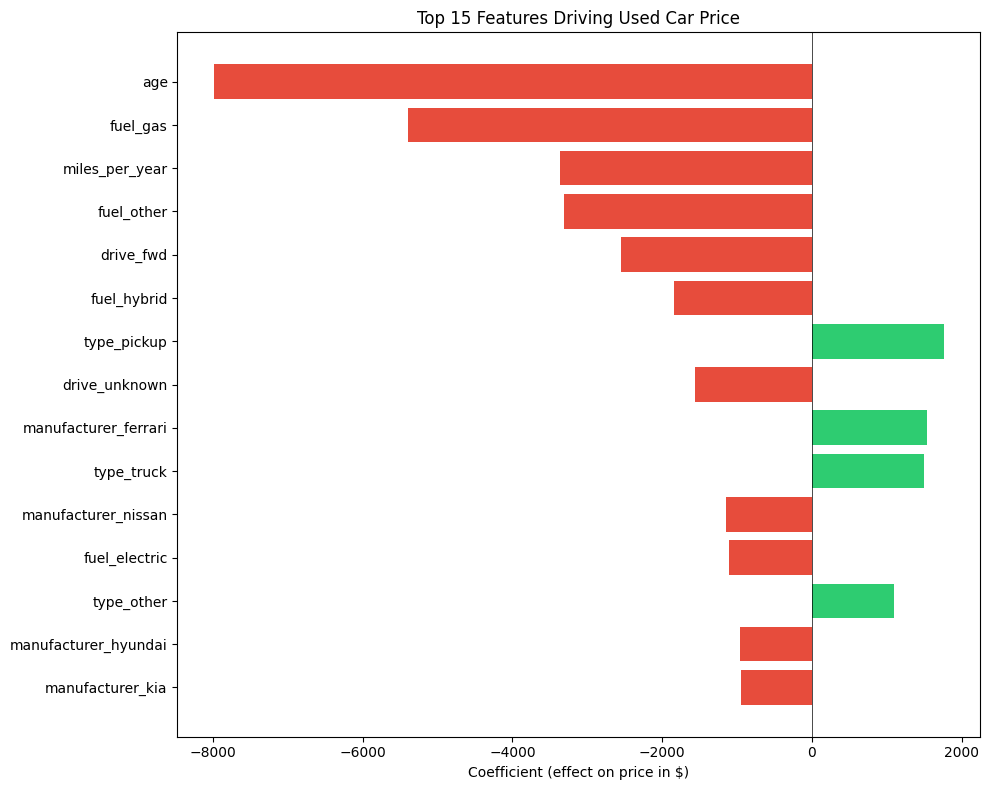

In [349]:
# --- Modeling: Step 8b — Visualize top coefficients ---

# Bar chart of the top 15 features by coefficient magnitude
top_15 = coeff_df.head(15).copy()
colors = ['#2ecc71' if c > 0 else '#e74c3c' for c in top_15['Coefficient']]

plt.figure(figsize=(10, 8))
plt.barh(top_15['Feature'][::-1], top_15['Coefficient'][::-1], color=colors[::-1])
plt.xlabel('Coefficient (effect on price in $)')
plt.title('Top 15 Features Driving Used Car Price')
plt.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

## Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [350]:
# --- Evaluation: Step 1 — Summarize model performance ---

# Reprint the comparison table and identify the best model
print("Final Model Comparison")
print("=" * 55)
print(results.to_string())
print(f"\nBest model: Ridge (alpha={best_alpha})")
print(f"  → Predicts used car prices within ±${best_rmse_test:,.0f} on average")
print(f"  → Explains {best_r2_test:.1%} of price variance")

Final Model Comparison
                   Test RMSE ($) Test R²
Model                                   
Linear Regression         $8,976  0.6326
Ridge (alpha=1.0)         $8,976  0.6326
Lasso (alpha=1.0)         $8,976  0.6326
Ridge (alpha=10.0)        $8,976  0.6326
Lasso (alpha=0.1)         $8,976  0.6326

Best model: Ridge (alpha=10.0)
  → Predicts used car prices within ±$8,976 on average
  → Explains 63.3% of price variance


#### Evaluation Reflection

**Is this model good enough for the business objective?**

Our best model (Ridge, alpha=10.0) achieves an R² of 0.6326 and an RMSE of $8,976. For a used car dealer making inventory decisions, this means:

- The model captures the **major pricing patterns** — age (↓$7,989), fuel type (gas ↓$5,396 vs. diesel), mileage intensity (↓$3,367), drivetrain, and vehicle type all contribute meaningfully.
- The ~$9K average error is reasonable for a market where listings range from $500 to $100K+, but the dealer should treat predictions as **directional guidance**, not exact appraisals.
- The 37% of unexplained variance likely comes from factors **not in our dataset**: vehicle condition (dropped — 41% missing), listing photos, descriptions, and local demand.

**An important observation:** All three models (Linear, Ridge α=1.0, Lasso α=1.0) produced identical results (RMSE $8,976, R² 0.6326). This tells us the data is well-conditioned — there isn't severe multicollinearity distorting coefficients. Regularization at the default alpha had no measurable effect. Even after tuning (Ridge α=10), the CV RMSE remained essentially flat at ~$10,300, confirming that the linear relationships in this dataset are straightforward and don't require regularization to stabilize.

**Do earlier phases need revisiting?**

- Dropping `condition` and `cylinders` was a trade-off. Both showed strong price signal in the assessment step, but were 41–42% missing. Imputing them could improve R².
- `model` (29K unique values) was dropped entirely. A frequency-based encoding or grouping into broader categories could recover some of that signal.
- Adding **interaction features** (e.g., `manufacturer × type`) could help — a Ford truck and a Ford sedan have very different price profiles.

**Key takeaway:** The model is useful for **ranking and comparing** vehicles in inventory, but should be supplemented with dealer expertise for final pricing decisions.

## Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

#### Findings & Recommendations for Used Car Dealers

Based on our analysis of 426,000+ used car listings and Ridge regression modeling (R² = 0.63, RMSE ≈ $9,000), here are the key factors that drive price and actionable recommendations for optimizing inventory:

**Top factors that drive price (from coefficient analysis):**

| Rank | Feature | Effect on Price | Interpretation |
|------|---------|----------------|----------------|
| 1 | `age` | ↓ $7,989 | The single strongest driver — newer cars sell for significantly more |
| 2 | `fuel_gas` | ↓ $5,396 | Gas vehicles are worth less than diesel — diesel trucks hold value |
| 3 | `miles_per_year` | ↓ $3,367 | Cars driven harder depreciate faster, even at the same age |
| 4 | `drive_fwd` | ↓ $2,556 | Front-wheel drive (sedans/compacts) commands lower prices than 4WD/RWD |
| 5 | `type_pickup` | ↑ $1,759 | Pickups sell at a premium over other vehicle types |
| 6 | `type_truck` | ↑ $1,495 | Trucks also command higher prices |
| 7 | `manufacturer_nissan/hyundai/kia` | ↓ ~$1,000 each | Budget brands consistently sell for less |

**Recommendations for the dealership:**

1. **Prioritize newer, low-mileage inventory** — Age and miles-per-year are the two largest price drivers. A 3-year-old car with 30K miles will outsell a 7-year-old car with the same mileage every time.
2. **Stock diesel trucks and pickups** — These categories command the highest premiums. Diesel fuel adds ~$5,400 over gas equivalents, and pickup/truck body types add $1,500–$1,800.
3. **Avoid over-investing in budget brands** — Nissan, Hyundai, and Kia listings sell for ~$1,000 less than average even after controlling for age, mileage, and type.
4. **Highlight 4WD/AWD in listings** — Front-wheel drive drops price by $2,500 vs. 4WD/RWD. If a vehicle has 4WD, make that prominent in the listing.
5. **Frame mileage as miles-per-year** — A 10-year-old car with 60K miles (6K/yr) is worth more than a 5-year-old car with 75K miles (15K/yr). Help buyers see this.

**Limitations:**
- The model explains 63% of price variance. The remaining 37% likely comes from listing quality, photos, local market conditions, negotiation, and vehicle condition (which was dropped due to 41% missing data).
- All three baseline models (Linear, Ridge α=1, Lasso α=1) produced identical results, suggesting the data is well-behaved and regularization only helps at higher alpha values.

**Next steps:**
- Impute `condition` and `cylinders` to recover those signals.
- I removed `model` because it had 29K unique values. A frequency-based encoding or grouping into broader categories could recover some of that signal.
   - **Frequency:** I could have had the feature not be the model name, but how popular that model is in the dataset (e.g., f-150 appears 8,009 times → high-demand model)
   - **Grouping:** I could have kept the top 20 or 50 most common models and lumped everything else into "other".